In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
train=pd.read_csv('../data/train.csv', index_col='ID_code')
test=pd.read_csv('../data/test.csv', index_col='ID_code')
submission=pd.read_csv('../data/sample_submission.csv')

In [4]:
x = train.loc[:,train.columns !='target']
print(x.shape)
x.head()

(200000, 200)


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,
train_0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
train_1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
train_2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
train_3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
train_4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
y = train['target']
print(y.shape)
y.head()

(200000,)


ID_code
train_0    0
train_1    0
train_2    0
train_3    0
train_4    0
Name: target, dtype: int64

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()

In [8]:
x=scaler.fit_transform(x)

In [9]:
x.mean(), x.std()

(-1.1152668122349497e-15, 1.0000000000000013)

In [10]:
y = np.array(y)

In [11]:
y = y.reshape(y.shape[0],1)

In [12]:
print(y.shape)
y

(200000, 1)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [14]:
from sklearn.model_selection import StratifiedKFold

In [26]:
n_splits = 5
splits = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
splits=list(splits.split(x,y))

In [33]:
print(len(splits))
splits[:3]

5


[(array([     1,      2,      3, ..., 199996, 199997, 199999]),
  array([     0,     11,     12, ..., 199988, 199992, 199998])),
 (array([     0,      1,      2, ..., 199997, 199998, 199999]),
  array([     4,     24,     32, ..., 199993, 199994, 199996])),
 (array([     0,      1,      2, ..., 199996, 199998, 199999]),
  array([     3,      8,     15, ..., 199979, 199980, 199997]))]

In [34]:
train, valid = next(iter(splits))

In [35]:
len(train), len(valid)

(159999, 40001)

In [38]:
class CyclicLR(object):
    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(type(optimizer).__name__))
        
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_heightclass CyclicLR(object):
    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs

SyntaxError: invalid syntax (<ipython-input-38-2772d8143820>, line 76)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size=0.3, random_state=42, shuffle=True)

In [14]:
x_train.shape, x_valid.shape,y_train.shape, y_valid.shape

((140000, 200), (60000, 200), (140000, 1), (60000, 1))

In [15]:
x_train=torch.FloatTensor(x_train)
x_valid=torch.FloatTensor(x_valid)
y_train=torch.FloatTensor(y_train)
y_valid=torch.FloatTensor(y_valid)

In [16]:
x_train.size(), x_valid.size(),y_train.size(), y_valid.size()

(torch.Size([140000, 200]),
 torch.Size([60000, 200]),
 torch.Size([140000, 1]),
 torch.Size([60000, 1]))

In [17]:
train = data_utils.TensorDataset(x_train, y_train)
valid = data_utils.TensorDataset(x_valid, y_valid)

In [18]:
trainloader = torch.utils.data.DataLoader(train, batch_size=20000, shuffle=True)
validloader = torch.utils.data.DataLoader(valid, batch_size=20000, shuffle=True)

In [19]:
train, label =next(iter(trainloader))

In [20]:
train.size(), label.size()

(torch.Size([20000, 200]), torch.Size([20000, 1]))

In [21]:
valid, label =next(iter(validloader))

In [22]:
valid.size(), label.size()

(torch.Size([20000, 200]), torch.Size([20000, 1]))

In [23]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(200, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)


        
        self.ac = nn.ReLU()
        self.dr = nn.Dropout(p=0.2)
        self.ac2 = nn.Sigmoid()
        
    def forward(self,x):
        x = self.dr(self.ac(self.fc1(x)))
        x = self.dr(self.ac(self.fc2(x)))
        x = self.ac2(self.fc3(x))

                    
        return x
        
model=Model()

model

Model(
  (fc1): Linear(in_features=200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
  (ac): ReLU()
  (dr): Dropout(p=0.2)
  (ac2): Sigmoid()
)

In [24]:
from sklearn.metrics import roc_auc_score

In [25]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [26]:
epochs = 50

train_loss =[]
valid_loss =[]
roc_auc_scores =[]


for e in range(epochs):
   
    running_losses = 0
    for trains, labels in trainloader:
        
        optimizer.zero_grad()
        
        output = model(trains)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_losses += loss.item()
        
    else:
        valid_losses= 0
        auc = 0
        
        model.eval()
        for valids, labels in validloader:
            ps = model(valids)
            valid_losses += criterion(ps, labels).item()
                
            labels = labels.data.numpy().astype('int32')    
            ps = ps.data.numpy()
                
            auc += roc_auc_score(labels, ps)
        
        train_loss.append(running_losses)
        valid_loss.append(valid_losses)
        roc_auc_scores.append(auc / (len(x_valid)/len(labels)))
        
        if e != 0 and max(roc_auc_scores) == roc_auc_scores[e]:
            torch.save(model, f'../model/model_nn{roc_auc_scores[e]: .3f}_{e}.pt')
            
                

        model.train()
        
        if e % 5 == 0:
            print(f"epoch: {e}/{epochs}", 
                  f"train_loss: {train_loss[e]: .3f}",
                  f"valid_loss: {valid_loss[e]: .3f}",
                  f"roc_auc_score: {roc_auc_scores[e]: .3f}")

epoch: 0/50 train_loss:  4.262 valid_loss:  1.608 roc_auc_score:  0.595


C:\Users\SKTelecom\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\SKTelecom\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\SKTelecom\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\SKTelecom\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Model. It won't b

epoch: 5/50 train_loss:  1.781 valid_loss:  0.762 roc_auc_score:  0.848


C:\Users\SKTelecom\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\SKTelecom\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch: 10/50 train_loss:  1.705 valid_loss:  0.748 roc_auc_score:  0.850
epoch: 15/50 train_loss:  1.646 valid_loss:  0.735 roc_auc_score:  0.849
epoch: 20/50 train_loss:  1.619 valid_loss:  0.735 roc_auc_score:  0.849
epoch: 25/50 train_loss:  1.599 valid_loss:  0.735 roc_auc_score:  0.848
epoch: 30/50 train_loss:  1.582 valid_loss:  0.736 roc_auc_score:  0.848
epoch: 35/50 train_loss:  1.576 valid_loss:  0.738 roc_auc_score:  0.847
epoch: 40/50 train_loss:  1.564 valid_loss:  0.740 roc_auc_score:  0.846
epoch: 45/50 train_loss:  1.558 valid_loss:  0.742 roc_auc_score:  0.845


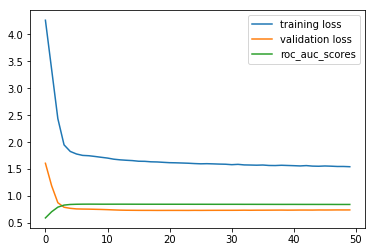

In [27]:
plt.plot(train_loss, label="training loss")
plt.plot(valid_loss, label="validation loss")
plt.plot(roc_auc_scores, label="roc_auc_scores")
plt.legend()

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

In [28]:
test = np.array(test)

In [29]:
test=scaler.fit_transform(test)

In [30]:
test.mean(), test.std()

(6.021986465043483e-16, 0.9999999999999997)

In [31]:
test=torch.FloatTensor(test)

In [32]:
print(f'model_path: ../model/model_nn{max(roc_auc_scores): .3f}_{roc_auc_scores.index(max(roc_auc_scores))}.pt')
model = torch.load(f'../model/model_nn{max(roc_auc_scores): .3f}_{roc_auc_scores.index(max(roc_auc_scores))}.pt')

model_path: ../model/model_nn 0.850_7.pt


In [33]:
model.eval()
output = model(test)

In [34]:
output=output.data.numpy()

In [35]:
submission['target'] = output

In [36]:
print(submission.shape)
submission.head()

(200000, 2)


,ID_code,target
0,test_0,0.300183
1,test_1,0.336425
2,test_2,0.027348
3,test_3,0.317039
4,test_4,0.064108


In [37]:
submission.to_csv(f'../submission/submission_nn{roc_auc_scores[e]: .3f}_190311.csv', index=False, header=True)